# Fully Convolutional Watershed Distance Transform for 2D Data
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [1]:
import os
import errno

import numpy as np

import sys
sys.path.insert(0,"/home/snn/deepcell-tf")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


import deepcell

In [2]:
import math
import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.optimizers import SGD

from tensorflow.python.keras.utils.data_utils import get_file

from deepcell import losses
import image_gen as image_gen
from deepcell import image_generators
from deepcell import model_zoo
from deepcell.layers import TensorProduct, ReflectionPadding3D, DilatedMaxPool3D

from deepcell.utils import train_utils
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.training import train_model_conv


from tensorflow.python.keras.layers import MaxPool3D
from conv_gru_layer import ConvGRU2D
from tensorflow.python.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.python.keras.layers import Conv3D, ZeroPadding3D, ConvLSTM2D, Cropping3D
from tensorflow.python.keras.layers import Input, Add, Concatenate, Flatten, Reshape
from tensorflow.python.keras.engine.input_layer import InputLayer

from tensorflow.python.keras.models import Model


from tensorflow.python.keras.regularizers import l2
from deepcell.layers import ImageNormalization2D, ImageNormalization3D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Softmax

from sklearn.model_selection import train_test_split

from tensorflow.python.client import device_lib

### Load the Training Data

In [3]:
# If DATA_FILE exists just run this cell

from deepcell.utils.data_utils import get_data

DATA_DIR = '/data/npz_data/tracking_benchmark_data'
DATA_FILE = os.path.join(DATA_DIR, '3T3_HeLa_HEK_RAW_cropped.npz')
# DATA_FILE = os.path.join(DATA_DIR, '3T3_HeLa_HEK_RAW_V2_stacked.npz')

# Load Information for hardcoded image size training
seed = 1
test_size = .2
train_dict, test_dict = get_data(DATA_FILE, seed=seed, test_size=test_size)
X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']

print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))

 -
X.shape: (642, 30, 135, 160, 1)
y.shape: (642, 30, 135, 160, 1)


### Set up filepath constants

In [4]:
# Set up other required filepaths
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)
ROOT_DIR = '/data' # mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

## Define feature net models

#### feature_net_3D is the gru analog of bn_feature_net_3D

In [5]:
def feature_net_3D(receptive_field=61,
                    n_frames=5,
                    input_shape=(5, 256, 256, 1),
                    n_features=3,
                    n_channels=1,
                    reg=1e-5,
                    n_conv_filters=64,
                    n_dense_filters=200,
                    VGG_mode=False,
                    init='he_normal',
                    norm_method='std',
                    location=False,
                    dilated=False,
                    padding=False,
                    padding_mode='reflect',
                    multires=False,
                    include_top=True,
                    gru=False,
                    gru_kernel_size =3):
    # Create layers list (x) to store all of the layers.
    # We need to use the functional API to enable the multiresolution mode
    x = []

    win = (receptive_field - 1) // 2
    win_z = (n_frames - 1) // 2

    if dilated:
        padding = True

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
        time_axis = 2
        row_axis = 3
        col_axis = 4
        if not dilated:
            input_shape = (n_channels, n_frames, receptive_field, receptive_field)
    else:
        channel_axis = -1
        time_axis = 1
        row_axis = 2
        col_axis = 3
        if not dilated:
            input_shape = (n_frames, receptive_field, receptive_field, n_channels)

    x.append(Input(shape=input_shape))
    x.append(ImageNormalization3D(norm_method=norm_method,
                                  filter_size=receptive_field)(x[-1]))

    if padding:
        if padding_mode == 'reflect':
            x.append(ReflectionPadding3D(padding=(win_z, win, win))(x[-1]))
        elif padding_mode == 'zero':
            x.append(ZeroPadding3D(padding=(win_z, win, win))(x[-1]))

    if location:
        x.append(Location3D(in_shape=tuple(x[-1].shape.as_list()[1:]))(x[-1]))
        x.append(Concatenate(axis=channel_axis)([x[-2], x[-1]]))

    layers_to_concat = []

    rf_counter = receptive_field
    block_counter = 0
    d = 1

    while rf_counter > 4:
        filter_size = 3 if rf_counter % 2 == 0 else 4
        x.append(Conv3D(n_conv_filters, (1, filter_size, filter_size),
                        dilation_rate=(1, d, d), kernel_initializer=init,
                        padding='valid', kernel_regularizer=l2(reg))(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        x.append(Activation('relu')(x[-1]))

        block_counter += 1
        rf_counter -= filter_size - 1

        if block_counter % 2 == 0:
            if dilated:
                x.append(DilatedMaxPool3D(dilation_rate=(1, d, d),
                                          pool_size=(1, 2, 2))(x[-1]))
                d *= 2
            else:
                x.append(MaxPool3D(pool_size=(1, 2, 2))(x[-1]))

            if VGG_mode:
                n_conv_filters *= 2

            rf_counter = rf_counter // 2

            if multires:
                layers_to_concat.append(len(x) - 1)

    if multires:
        c = []
        for l in layers_to_concat:
            output_shape = x[l].get_shape().as_list()
            target_shape = x[-1].get_shape().as_list()
            time_crop = (0, 0)

            row_crop = int(output_shape[row_axis] - target_shape[row_axis])

            if row_crop % 2 == 0:
                row_crop = (row_crop // 2, row_crop // 2)
            else:
                row_crop = (row_crop // 2, row_crop // 2 + 1)

            col_crop = int(output_shape[col_axis] - target_shape[col_axis])

            if col_crop % 2 == 0:
                col_crop = (col_crop // 2, col_crop // 2)
            else:
                col_crop = (col_crop // 2, col_crop // 2 + 1)

            cropping = (time_crop, row_crop, col_crop)

            c.append(Cropping3D(cropping=cropping)(x[l]))
        x.append(Concatenate(axis=channel_axis)(c))

    x.append(Conv3D(n_dense_filters, (1, rf_counter, rf_counter),
                    dilation_rate=(1, d, d), kernel_initializer=init,
                    padding='valid', kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(Conv3D(n_dense_filters, (n_frames, 1, 1), dilation_rate=(1, d, d),
                    kernel_initializer=init, padding='valid',
                    kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))
    
    if gru is True:
        x.append(ConvGRU2D(filters=n_conv_filters, kernel_size=gru_kernel_size,
                            padding='same', kernel_initializer=init, activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        x.append(ConvGRU2D(filters=n_conv_filters, kernel_size=gru_kernel_size+2,
                            padding='same', kernel_initializer=init, activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))

    x.append(TensorProduct(n_dense_filters, kernel_initializer=init,
                           kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(TensorProduct(n_features, kernel_initializer=init,
                           kernel_regularizer=l2(reg))(x[-1]))

    if not dilated:
        x.append(Flatten()(x[-1]))

    if include_top:
        x.append(Softmax(axis=channel_axis)(x[-1]))

    model = Model(inputs=x[0], outputs=x[-1])

    return model

#### feature_net_skip_3D is the gru analog of bn_feature_net_skip_3D

In [6]:
def feature_net_skip_3D(receptive_field=61,
                        input_shape=(5, 256, 256, 1),
                        fgbg_model=None,
                        gru=False,
                        gru_kernel_size=3,
                        last_only=True,
                        n_skips=1,
                        norm_method='whole_image',
                        padding_mode='reflect',
                        **kwargs):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    inputs = Input(shape=input_shape)
    img = ImageNormalization3D(norm_method=norm_method,
                               filter_size=receptive_field)(inputs)

    models = []
    model_outputs = []

    if fgbg_model is not None:
        for layer in fgbg_model.layers:
            layer.trainable = False
        models.append(fgbg_model)
        fgbg_output = fgbg_model(inputs)
        if isinstance(fgbg_output, list):
            fgbg_output = fgbg_output[-1]
        model_outputs.append(fgbg_output)

    for _ in range(n_skips + 1):
        if model_outputs:
            model_input = Concatenate(axis=channel_axis)([img, model_outputs[-1]])
        else:
            model_input = img

        new_input_shape = model_input.get_shape().as_list()[1:]
        models.append(feature_net_3D(receptive_field=receptive_field, 
                                     input_shape=new_input_shape, 
                                     norm_method=None, 
                                     dilated=True, 
                                     padding=True, 
                                     padding_mode=padding_mode, 
                                     gru=gru, 
                                     gru_kernel_size=gru_kernel_size, 
                                     **kwargs))
        model_outputs.append(models[-1](model_input))

    if last_only:
        model = Model(inputs=inputs, outputs=model_outputs[-1])
    elif fgbg_model is None:
        model = Model(inputs=inputs, outputs=model_outputs)
    else:
        model = Model(inputs=inputs, outputs=model_outputs[1:])
        
    model.summary()
    return model

#### Test Generator

In [7]:
DataGenerator = image_generators.MovieDataGenerator

datagen = DataGenerator(
    rotation_range=180,
    shear_range=False,
    zoom_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = DataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)


train_data = datagen.flow(
    train_dict,
    skip=3,
    seed=0,
    batch_size=1,
    transform='fgbg',
    transform_kwargs={},
    frames_per_batch=3)

val_data = datagen_val.flow(
    test_dict,
    skip=3,
    seed=0,
    batch_size=1,
    transform='fgbg',
    transform_kwargs={},
    frames_per_batch=3)

(642, 30, 135, 160, 1)
Image number: 456
Frame number: 8


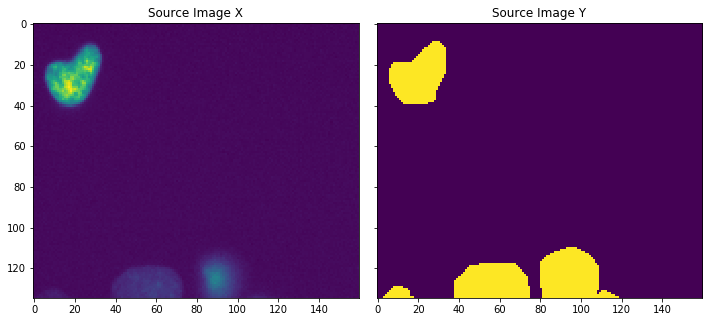

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

print(train_data.x.shape)

index = np.random.randint(low=0, high=train_data.x.shape[0])
frame = np.random.randint(low=0, high=train_data.x.shape[1])
print('Image number:', index)
print('Frame number:', frame)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(train_data.x[index, frame, ..., 0])
ax[0].set_title('Source Image X')

ax[1].imshow(train_data.y[index, frame, ..., 1])
ax[1].set_title('Source Image Y')

fig.tight_layout()
plt.show()

## Train the Model

### Training Parameters

In [25]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'trackingSEG_cropped_conv_gru_fgbg_model_10e'
conv_model_name = 'trackingSEG_cropped_conv_gru_watershed_model_10e'

n_epoch = 5  # Number of training epochs
norm_method = 'whole_image'  # data normalization - `whole_image` for 3d conv
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'watershed'
distance_bins = 4  # number of distance classes
erosion_width = 1  # erode edges, improves segmentation when cells are close

# 3D Settings
frames_per_batch = 3

# GRU Settings
is_gru = False
gru_kernel_size = 3

### Foreground Background Model

#### (1) Instantiate the fgbg model

In [26]:
fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            gru=is_gru,
            gru_kernel_size=gru_kernel_size,
            input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
            last_only=False,
            norm_method=norm_method)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
image_normalization3d_50 (Image (None, 3, 135, 160,  0           input_51[0][0]                   
__________________________________________________________________________________________________
model_50 (Model)                (None, 3, 135, 160,  213570      image_normalization3d_50[0][0]   
__________________________________________________________________________________________________
concatenate_35 (Concatenate)    (None, 3, 135, 160,  0           image_normalization3d_50[0][0]   
                                                                 model_50[1][0]                   
__________

In [27]:
fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_fgbg_model.h5')

#### (2) Train the fgbg model

In [28]:
from deepcell.training import train_model_conv

fgbg_model_name = 'trackingSEG_cropped_conv_fgbg_model_10e'

fgbg_model = train_model_conv(
        model=fgbg_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=fgbg_model_name,
        log_dir=LOG_DIR,
        transform='fgbg',
        optimizer=optimizer,
        batch_size=batch_size,
        frames_per_batch=frames_per_batch,
        n_epoch=n_epoch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=(0.8, 1.2))

fgbg_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
fgbg_model.save_weights(fgbg_weights_file)

X_train shape: (642, 30, 135, 160, 1)
y_train shape: (642, 30, 135, 160, 1)
X_test shape: (161, 30, 135, 160, 1)
y_test shape: (161, 30, 135, 160, 1)
Output Shape: (None, 3, 135, 160, 2)
Number of Classes: 2
Training on 1 GPUs
Epoch 1/5
641/642 [============================>.] - ETA: 0s - loss: 0.4178 - model_50_loss: 0.0948 - model_51_loss: 0.0918 - model_52_loss: 0.0914 - model_53_loss: 0.0925 - model_50_acc: 0.9610 - model_51_acc: 0.9613 - model_52_acc: 0.9619 - model_53_acc: 0.9611
Epoch 00001: saving model to /data/models/trackingSEG_cropped_conv_fgbg_model_10e.h5
642/642 [==============================] - 401s 625ms/step - loss: 0.4178 - model_50_loss: 0.0948 - model_51_loss: 0.0917 - model_52_loss: 0.0915 - model_53_loss: 0.0925 - model_50_acc: 0.9610 - model_51_acc: 0.9614 - model_52_acc: 0.9619 - model_53_acc: 0.9612 - val_loss: 0.4499 - val_model_50_loss: 0.1045 - val_model_51_loss: 0.0940 - val_model_52_loss: 0.1038 - val_model_53_loss: 0.1003 - val_model_50_acc: 0.9571 - va

### Watershed energy transform

#### (1) Load weights for fgbg model if necessary

In [13]:
fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            gru=is_gru,
            gru_kernel_size=gru_kernel_size,
            input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
            last_only=False)

fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_fgbg_model.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
image_normalization3d_15 (Image (None, 3, 135, 160,  0           input_16[0][0]                   
__________________________________________________________________________________________________
model_15 (Model)                (None, 3, 135, 160,  213570      image_normalization3d_15[0][0]   
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 3, 135, 160,  0           image_normalization3d_15[0][0]   
                                                                 model_15[1][0]                   
__________

#### (2) Instantiate the distance transform model 

In [29]:
watershed_model = feature_net_skip_3D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,  # (background edge, interior edge, cell interior, background)
    n_frames=frames_per_batch,
    n_conv_filters=32,
    n_dense_filters=128,
    gru=is_gru,
    gru_kernel_size=gru_kernel_size,
    multires=False,
    last_only=False,
    input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
    norm_method=norm_method)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_56 (InputLayer)           (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
image_normalization3d_55 (Image (None, 3, 135, 160,  0           input_56[0][0]                   
__________________________________________________________________________________________________
model_54 (Model)                [(None, 3, 135, 160, 857352      input_56[0][0]                   
__________________________________________________________________________________________________
concatenate_38 (Concatenate)    (None, 3, 135, 160,  0           image_normalization3d_55[0][0]   
                                                                 model_54[1][3]                   
__________

In [30]:
watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_watershed_model.h5')

#### (3) Train the distance transform model

In [31]:
conv_model_name = 'trackingSEG_cropped_conv_watershed_model_10e'

watershed_model = train_model_conv(
        model=watershed_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=conv_model_name,
        test_size=test_size,
        seed=seed,
        transform=transform,
        distance_bins=distance_bins,
        erosion_width=erosion_width,
        optimizer=optimizer,
        batch_size=batch_size,
        n_epoch=n_epoch,
        frames_per_batch=frames_per_batch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=(0.8, 1.2))

watershed_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(conv_model_name))
watershed_model.save_weights(watershed_weights_file)

X_train shape: (642, 30, 135, 160, 1)
y_train shape: (642, 30, 135, 160, 1)
X_test shape: (161, 30, 135, 160, 1)
y_test shape: (161, 30, 135, 160, 1)
Output Shape: (None, 3, 135, 160, 4)
Number of Classes: 4
Training on 1 GPUs
Epoch 1/5
641/642 [============================>.] - ETA: 0s - loss: 2.6092 - model_55_loss: 0.6404 - model_56_loss: 0.6259 - model_57_loss: 0.6247 - model_58_loss: 0.6205 - model_55_acc: 0.8789 - model_56_acc: 0.8818 - model_57_acc: 0.8815 - model_58_acc: 0.8820
Epoch 00001: saving model to /data/models/trackingSEG_cropped_conv_watershed_model_10e.h5
642/642 [==============================] - 445s 693ms/step - loss: 2.6083 - model_55_loss: 0.6402 - model_56_loss: 0.6257 - model_57_loss: 0.6245 - model_58_loss: 0.6203 - model_55_acc: 0.8790 - model_56_acc: 0.8819 - model_57_acc: 0.8816 - model_58_acc: 0.8821 - val_loss: 2.5728 - val_model_55_loss: 0.6574 - val_model_56_loss: 0.5976 - val_model_57_loss: 0.6162 - val_model_58_loss: 0.6039 - val_model_55_acc: 0.8879

# Run the model

#### Make predictions on test data

In [130]:
is_gru = True

run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            gru=is_gru,
            gru_kernel_size=gru_kernel_size,
            input_shape=tuple(X_test.shape[1:]),
            last_only=False,
            norm_method=norm_method)

run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_fgbg_model.h5')

run_watershed_model = feature_net_skip_3D(
                        fgbg_model=run_fgbg_model,
                        receptive_field=receptive_field,
                        n_skips=n_skips,
                        n_features=distance_bins,
                        n_frames=frames_per_batch,
                        n_conv_filters=32,
                        n_dense_filters=128,
                        multires=False,
                        last_only=False,
                        input_shape=tuple(X_test.shape[1:]),
                        norm_method=norm_method,
                        gru=is_gru,
                        gru_kernel_size=3)

run_watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_watershed_model.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_106 (InputLayer)          (None, 30, 135, 160, 0                                            
__________________________________________________________________________________________________
image_normalization3d_105 (Imag (None, 30, 135, 160, 0           input_106[0][0]                  
__________________________________________________________________________________________________
model_105 (Model)               (None, 30, 135, 160, 493570      image_normalization3d_105[0][0]  
__________________________________________________________________________________________________
concatenate_73 (Concatenate)    (None, 30, 135, 160, 0           image_normalization3d_105[0][0]  
                                                                 model_105[1][0]                  
__________

In [131]:
# make predictions on testing data
test_images = run_watershed_model.predict(X_test[:1, :, :, :, :])[-1]
test_images_fgbg = run_fgbg_model.predict(X_test[:1, :, :, :, :])[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (1, 30, 135, 160, 4)
segmentation mask shape: (1, 30, 135, 160, 2)


### Watershed post-processing

In [132]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

watershed argmax shape: (1, 30, 135, 160, 1)


In [133]:
# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [134]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max
from skimage.segmentation import relabel_sequential
from skimage.measure import label, regionprops

watershed_images = []
perimeter_area_threshold = 2
foreground = argmax_images_post_fgbg > 0
small_objects_threshold = 100

for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    semantic = fg_thresh[i]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    
    
    semantic_argmax = argmax_images[i]
    
    watershed_sub_array = []
    for i, segments_semantic in enumerate(segments):
        masks_concat = image[i:i+1]
        markers_semantic = markers[i]

        # Remove misshapen watershed cells
        props = regionprops(segments_semantic)
        for prop in props:
            if prop.perimeter ** 2 / prop.area > perimeter_area_threshold * 4 * np.pi:
                segments_semantic[segments_semantic == prop.label] = 0

        masks_semantic = np.zeros((np.amax(segments_semantic).astype(int),
                                   semantic.shape[1], semantic.shape[2]))
        
        for j in range(0, masks_semantic.shape[0] + 1):
            masks_semantic[j - 1] = segments_semantic == j
            
        masks_concat = np.concatenate([masks_concat, masks_semantic], axis=0)
        # print("masks_concat", masks_concat.shape)
        label_image = np.sum(masks_concat, axis=0).astype(int)
        # print("label_image", label_image.shape)
        # Remove small objects
        label_image = remove_small_objects(label_image, min_size=small_objects_threshold)
        # Relabel the label image
        label_image = label(label_image)
        # print("label_image", label_image.shape)
        watershed_sub_array.append(label_image)
    watershed_images.append(watershed_sub_array)
        
watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=-1)


### Plot the Results

Image number: 0
Frame: 18
(1, 30, 135, 160, 1)


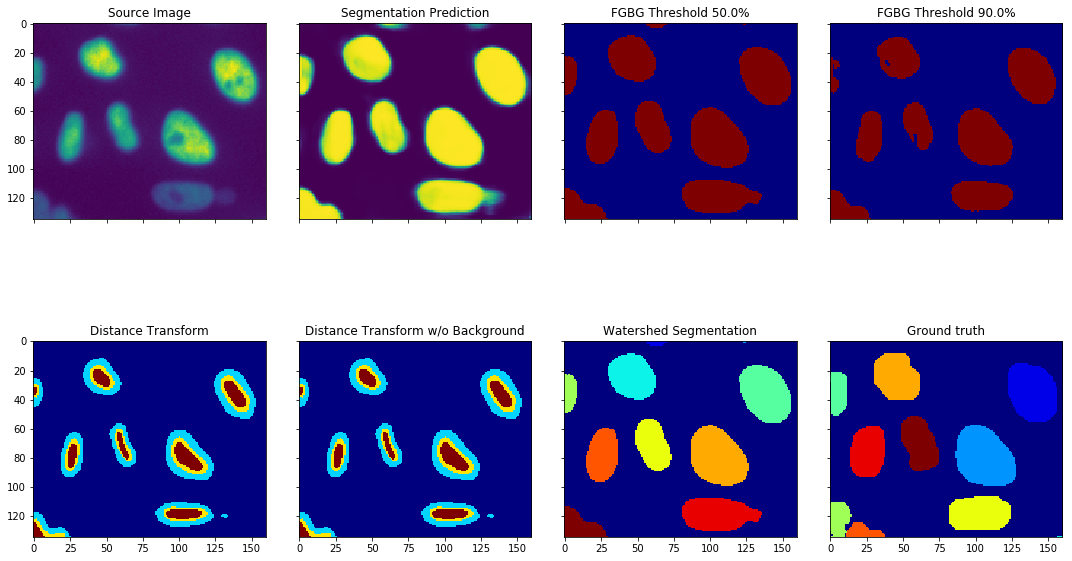

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline

index = np.random.randint(low=0, high=1)
frame = np.random.randint(low=0, high=X_test.shape[1])
print('Image number:', index)
print('Frame:', frame)

print(watershed_images.shape)

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

fg_thresh_90 = test_images_fgbg[..., 1] > 0.9
fg_thresh_90 = np.expand_dims(fg_thresh_90.astype('int16'), axis=-1)
ax[3].imshow(fg_thresh_90[index, frame, ..., 0], cmap='jet')
ax[3].set_title('FGBG Threshold {}%'.format(0.9 * 100))

ax[4].imshow(argmax_images[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform')

ax[5].imshow(argmax_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Distance Transform w/o Background')

ax[6].imshow(watershed_images[index, frame, ..., 0], cmap='jet')
ax[6].set_title('Watershed Segmentation')

ax[7].imshow(y_test[index, frame, ..., 0], cmap='jet')
ax[7].set_title('Ground truth')

fig.tight_layout()
plt.show()
# plt.savefig('test.png')

### Run the Model Iteratively

In [32]:
# Define the Datasets

###### For Deepcell Datasets

# Define data to load (raw images from trk test files)
RAW_BASE_DIR = '/data/npz_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

# raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa]
raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa, raw_trks_RAW]

# Define a base file name for the output
BASE_NAME = 'batch_'

In [169]:
# Make predictions on test data
from deepcell.utils.tracking_utils import load_trks
from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics
from skimage.measure import label
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max

# CELL_TYPE_NAME = ['3T3', 'HEK293', 'HeLa']
CELL_TYPE_NAME = ['3T3', 'HEK293', 'HeLa', 'RAW264']
is_gru = False
perimeter_area_threshold = 2

# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.9
Lstats_AllDatasets = []
# Go through each Dataset (3T3, HEK293, HeLa, RAW264.7)
for set_num, dataset in enumerate(raw_trks_files):
    # Load the trk file       
    trks = load_trks(dataset)
    lineages, raw, tracked = trks['lineages'], trks['X'], trks['y']
    # y_new = np.zeros(tracked.shape)
    
    run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            gru=is_gru,
            gru_kernel_size=gru_kernel_size,
            input_shape=tuple(trks['X'].shape[1:]),
            last_only=False,
            norm_method=norm_method)

    run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_fgbg_model.h5')

    run_watershed_model = feature_net_skip_3D(
                        fgbg_model=run_fgbg_model,
                        receptive_field=receptive_field,
                        n_skips=n_skips,
                        n_features=distance_bins,
                        n_frames=frames_per_batch,
                        n_conv_filters=32,
                        n_dense_filters=128,
                        multires=False,
                        last_only=False,
                        input_shape=tuple(trks['X'].shape[1:]),
                        norm_method=norm_method,
                        gru=is_gru,
                        gru_kernel_size=3)

    run_watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_watershed_model.h5')
    
    Lstats_allmovies = []

    # Go through each batch (movie) in each dataset
    for batch_num, movie in enumerate(trks['X']):

        Lstats = []
        
        # Predict on the raw data
        X_test_temp = np.expand_dims(movie, axis=0)
        print("X_test_temp.shape", X_test_temp.shape)
        test_images = run_watershed_model.predict(X_test_temp)[-1]
        test_images_fgbg = run_fgbg_model.predict(X_test_temp)[-1]
        
        # Postprocessing
        # Collapse predictions into semantic segmentation mask
        argmax_images = []
        for frame_num, frame in enumerate(test_images):
            max_image = np.argmax(frame, axis=-1)
            argmax_images.append(max_image)
        argmax_images = np.array(argmax_images)
        argmax_images = np.expand_dims(argmax_images, axis=-1)
        
        # threshold the foreground/background
        # and remove background from watershed transform
        fg_thresh = test_images_fgbg[..., 1] > threshold
        fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
        argmax_images_post_fgbg = argmax_images * fg_thresh
        watershed_images = []
        
        for i in range(argmax_images_post_fgbg.shape[0]):
            image = fg_thresh[i, ..., 0]
            semantic = fg_thresh[i]
            distance = argmax_images_post_fgbg[i, ..., 0]

            local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                        exclude_border=False, indices=False, labels=image)

            markers = label(local_maxi)
            segments = watershed(-distance, markers, mask=image)


            semantic_argmax = argmax_images[i]

            watershed_sub_array = []
            for i, segments_semantic in enumerate(segments):
                masks_concat = image[i:i+1]
                markers_semantic = markers[i]

                # Remove misshapen watershed cells
                props = regionprops(segments_semantic)
                for prop in props:
                    if prop.perimeter ** 2 / prop.area > perimeter_area_threshold * 4 * np.pi:
                        segments_semantic[segments_semantic == prop.label] = 0

                masks_semantic = np.zeros((np.amax(segments_semantic).astype(int),
                                           semantic.shape[1], semantic.shape[2]))

                for j in range(0, masks_semantic.shape[0] + 1):
                    masks_semantic[j - 1] = segments_semantic == j

                masks_concat = np.concatenate([masks_concat, masks_semantic], axis=0)
                # print("masks_concat", masks_concat.shape)
                label_image = np.sum(masks_concat, axis=0).astype(int)
                # print("label_image", label_image.shape)
                # Remove small objects
                label_image = remove_small_objects(label_image, min_size=small_objects_threshold)
                # Relabel the label image
                label_image = label(label_image)
                # print("label_image", label_image.shape)
                watershed_sub_array.append(label_image)
            watershed_images.append(watershed_sub_array)

        watershed_images = np.array(watershed_images)
        watershed_images = np.expand_dims(watershed_images, axis=-1)
        print("watershed_images.shape", watershed_images.shape)
        
        # Remove small objects from GT for comparison
        small_objects_threshold=100
        for frame_num, watershed_image in enumerate(watershed_images):
            # Remove small objects from GT for comparison
            GT_image = trks['y'][batch_num, frame_num, :, :, :]
            GT_image = np.expand_dims(GT_image, axis=0)
            GT_image = morphology.remove_small_objects(GT_image.astype('uint16'), min_size=small_objects_threshold)
            
            # Accuracy from metrics package
            filename = CELL_TYPE_NAME[set_num] + BASE_NAME + '{}'.format(batch_num)
            
            m = metrics.Metrics(model_name = filename)
            m.calc_object_stats(GT_image, watershed_image)
            
            # Store results
            # y_new[batch_num, frame_num, :, :, :] = watershed_image
            Lstats.append(m.stats)
            
        Lstats_allmovies.append(Lstats)
        
    Lstats_AllDatasets.append(Lstats_allmovies)

df_3T3    = pd.concat([pd.concat(Lstats_AllDatasets[0][i]) for i in range(len(Lstats_AllDatasets[0]))])
df_HEK293 = pd.concat([pd.concat(Lstats_AllDatasets[1][i]) for i in range(len(Lstats_AllDatasets[1]))])
df_HeLa   = pd.concat([pd.concat(Lstats_AllDatasets[2][i]) for i in range(len(Lstats_AllDatasets[2]))])
df_RAW264 = pd.concat([pd.concat(Lstats_AllDatasets[3][i]) for i in range(len(Lstats_AllDatasets[3]))])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_326 (InputLayer)          (None, 30, 154, 182, 0                                            
__________________________________________________________________________________________________
image_normalization3d_325 (Imag (None, 30, 154, 182, 0           input_326[0][0]                  
__________________________________________________________________________________________________
model_325 (Model)               (None, 30, 154, 182, 213570      image_normalization3d_325[0][0]  
__________________________________________________________________________________________________
concatenate_227 (Concatenate)   (None, 30, 154, 182, 0           image_normalization3d_325[0][0]  
                                                                 model_325[1][0]                  
__________

/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:801: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['gained_detections'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:804: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['missed_detections'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:807: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['merge'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:810: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['split'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:813: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['catastrophe'].sum() / total_e

watershed_images.shape (1, 30, 154, 182, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88782664117272147574766449906746856868267059326171875 

X_test_temp.shape (1, 30, 154, 182, 1)
watershed_images.shape (1, 30, 154, 182, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 9

Correct detections:  8	Recall: 100%
Incorrect detections: 1	Precision: 88.888888888888885

watershed_images.shape (1, 30, 154, 182, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 12

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 2	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90346779900920026751265368147869594395160675048828125 

X_test_temp.shape (1, 30, 154, 182, 1)
watershed_images.shape (1, 30, 154, 182, 1)
INFO:tensorflow:0 samples processed

____________Ob

watershed_images.shape (1, 30, 154, 182, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 15

Correct detections:  7	Recall: 70%
Incorrect detections: 8	Precision: 46.66666666666666429819088079966604709625244140625%

Gained detections: 7	Perc Error: 77.77777777777777146184234879910945892333984375%
Missed detections: 1	Perc Error: 11.111111111111110716365146799944341182708740234375%
Merges: 1		Perc Error: 11.111111111111110716365146799944341182708740234375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.712423088192206233060232989373616874217987060546875 

__________________________________________________________________________________________________
Layer (type)                    Ou

watershed_images.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 10

Correct detections:  7	Recall: 43.75%
Incorrect detections: 3	Precision: 70%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 3		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 6
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.853441894892672081596174393780529499053955078125 

X_test_temp.shape (1, 30, 135, 160, 1)
watershed_images.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  9	Recall: 75%
Incorrect detections: 1	Precision: 90%

Gained detections: 0	P

watershed_images.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  12	Recall: 80%
Incorrect detections: 3	Precision: 80%

Gained detections: 2	Perc Error: 50%
Missed detections: 1	Perc Error: 25%
Merges: 1		Perc Error: 25%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.875226039783001841243503804435022175312042236328125 

X_test_temp.shape (1, 30, 135, 160, 1)
watershed_images.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 15

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect de

watershed_images.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 9

Correct detections:  6	Recall: 60%
Incorrect detections: 3	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 0	Perc Error: 0%
Merges: 2		Perc Error: 66.6666666666666714036182384006679058074951171875%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82597054886211507263027442604652605950832366943359375 

X_test_temp.shape (1, 30, 135, 160, 1)
watershed_images.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of tru

watershed_images.shape (1, 40, 216, 256, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 13

Correct detections:  8	Recall: 72.7272727272727337322066887281835079193115234375%
Incorrect detections: 5	Precision: 61.53846153846154010125246713869273662567138671875%

Gained detections: 5	Perc Error: 62.5%
Missed detections: 3	Perc Error: 37.5%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.59977116704805488733853735539014451205730438232421875 

X_test_temp.shape (1, 40, 216, 256, 1)
watershed_images.shape (1, 40, 216, 256, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

watershed_images.shape (1, 40, 216, 256, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8094719651605879473521554245962761342525482177734375 

X_test_temp.shape (1, 40, 216, 256, 1)
watershed_images.shape (1, 40, 216, 256, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 4

Correct detections:  1	Recall: 20%
Incorrect detections: 3	Precision: 25%

Gained detectio

watershed_images.shape (1, 30, 202, 240, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  15	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7888033961262934656843981429119594395160675048828125 

X_test_temp.shape (1, 30, 202, 240, 1)
watershed_images.shape (1, 30, 202, 240, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 4

Correct detections:  3	Recall: 50%
Incorrect detections: 1	Precision: 75%

Gained detec

In [170]:
# CELL_TYPE_DF = [df_3T3, df_HEK293, df_HeLa]

CELL_TYPE_DF = [df_3T3, df_HEK293, df_HeLa, df_RAW264]

for cell_type, df in zip(CELL_TYPE_NAME, CELL_TYPE_DF):
    print('\n')
    print(cell_type)
    print('\n')
    # Total number of correct detections and incorrect detections
    correct_det = int(df['correct_detections'].sum())
    incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

    print('Correct Detections: ', correct_det)
    print('Incorrect Detections: ', incorrect_det)
    
    # Total number of splits, merges, and catastrophes
    splits = df['split'].sum()
    merges = df['merge'].sum()
    catastrophes = df['catastrophe'].sum()
    
    print('Splits: ', splits)
    print('Merges: ', merges)
    print('Catastrophes: ', catastrophes)

    # Average Recall, Precision, and Jaccard Index
    recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
    precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
    jaccard = df['jaccard'].mean()

    print('Recall: ', recall)
    print('Precision: ', precision)
    print('Average Jaccard Index: ', jaccard)



3T3


Correct Detections:  175
Incorrect Detections:  40
Splits:  0
Merges:  5
Catastrophes:  0
Recall:  86.20689655172414
Precision:  81.3953488372093
Average Jaccard Index:  0.780758783658973


HEK293


Correct Detections:  219
Incorrect Detections:  111
Splits:  1
Merges:  51
Catastrophes:  3
Recall:  57.63157894736842
Precision:  66.36363636363636
Average Jaccard Index:  0.8520511618879577


HeLa


Correct Detections:  95
Incorrect Detections:  36
Splits:  0
Merges:  5
Catastrophes:  0
Recall:  69.8529411764706
Precision:  72.51908396946565
Average Jaccard Index:  0.7160869988674958


RAW264


Correct Detections:  109
Incorrect Detections:  23
Splits:  0
Merges:  7
Catastrophes:  0
Recall:  78.98550724637681
Precision:  82.57575757575758
Average Jaccard Index:  0.7332733279560915


## See what it looks like on the different data sets

In [43]:
RAW_BASE_DIR = '/data/npz_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

#### Predict on dataset

In [147]:
from deepcell.utils.tracking_utils import load_trks
from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

trks = load_trks(raw_trks_HeLa)
lineages, X_test, y_test = trks['lineages'], trks['X'], trks['y']

run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            gru=is_gru,
            gru_kernel_size=gru_kernel_size,
            input_shape=tuple(X_test.shape[1:]),
            last_only=False,
            norm_method=norm_method)

run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_fgbg_model.h5')

run_watershed_model = feature_net_skip_3D(
                    fgbg_model=run_fgbg_model,
                    receptive_field=receptive_field,
                    n_skips=n_skips,
                    n_features=distance_bins,
                    n_frames=frames_per_batch,
                    n_conv_filters=32,
                    n_dense_filters=128,
                    multires=False,
                    last_only=False,
                    input_shape=tuple(X_test.shape[1:]),
                    norm_method=norm_method,
                    gru=is_gru,
                    gru_kernel_size=3)

run_watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_watershed_model.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_316 (InputLayer)          (None, 40, 216, 256, 0                                            
__________________________________________________________________________________________________
image_normalization3d_315 (Imag (None, 40, 216, 256, 0           input_316[0][0]                  
__________________________________________________________________________________________________
model_315 (Model)               (None, 40, 216, 256, 493570      image_normalization3d_315[0][0]  
__________________________________________________________________________________________________
concatenate_220 (Concatenate)   (None, 40, 216, 256, 0           image_normalization3d_315[0][0]  
                                                                 model_315[1][0]                  
__________

In [149]:
# make predictions on testing data
test_images = run_watershed_model.predict(X_test[:1, :, :, :, :])[-1]
test_images_fgbg = run_fgbg_model.predict(X_test[:1, :, :, :, :])[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (1, 40, 216, 256, 4)
segmentation mask shape: (1, 40, 216, 256, 2)


#### Post-process

In [161]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

watershed argmax shape: (1, 40, 216, 256, 1)


In [167]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max
from skimage.segmentation import relabel_sequential
from skimage.measure import label, regionprops

watershed_images = []
perimeter_area_threshold = 2
foreground = argmax_images_post_fgbg > 0
small_objects_threshold = 50

for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    semantic = fg_thresh[i]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    
    
    semantic_argmax = argmax_images[i]
    
    watershed_sub_array = []
    for i, segments_semantic in enumerate(segments):
        masks_concat = image[i:i+1]
        markers_semantic = markers[i]

        # Remove misshapen watershed cells
        props = regionprops(segments_semantic)
        for prop in props:
            if prop.perimeter ** 2 / prop.area > perimeter_area_threshold * 4 * np.pi:
                segments_semantic[segments_semantic == prop.label] = 0

        masks_semantic = np.zeros((np.amax(segments_semantic).astype(int),
                                   semantic.shape[1], semantic.shape[2]))
        
        for j in range(0, masks_semantic.shape[0] + 1):
            masks_semantic[j - 1] = segments_semantic == j
            
        masks_concat = np.concatenate([masks_concat, masks_semantic], axis=0)
        # print("masks_concat", masks_concat.shape)
        label_image = np.sum(masks_concat, axis=0).astype(int)
        # print("label_image", label_image.shape)
        # Remove small objects
        label_image = remove_small_objects(label_image, min_size=small_objects_threshold)
        # Relabel the label image
        label_image = label(label_image)
        # print("label_image", label_image.shape)
        watershed_sub_array.append(label_image)
    watershed_images.append(watershed_sub_array)
        
watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=-1)


Image number: 0
Frame: 22


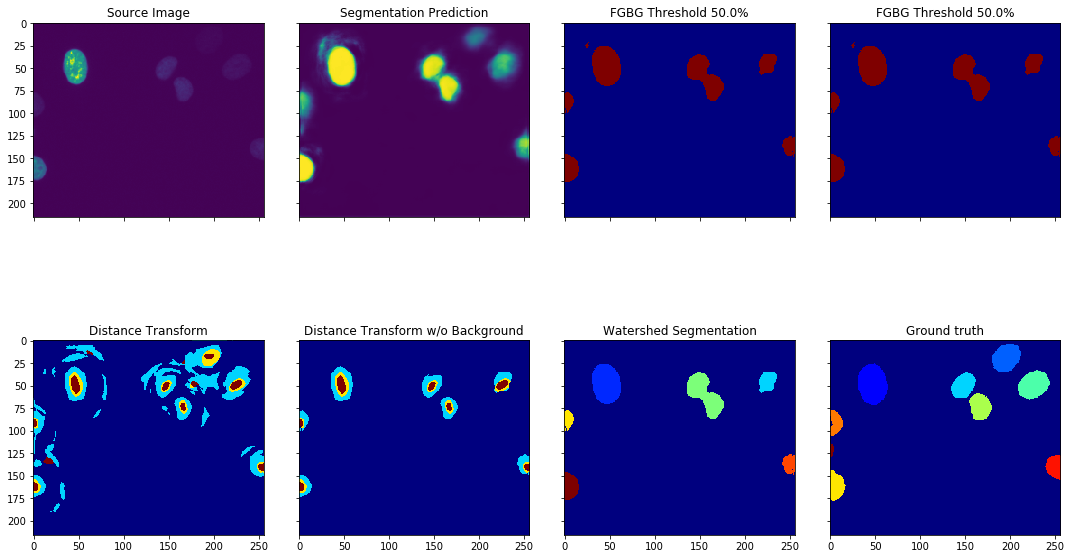

In [168]:
import matplotlib.pyplot as plt
%matplotlib inline

index = np.random.randint(low=0, high=1)
frame = np.random.randint(low=0, high=X_test.shape[1])
print('Image number:', index)
print('Frame:', frame)



fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

fg_thresh_90 = test_images_fgbg[..., 1] > 0.5
fg_thresh_90 = np.expand_dims(fg_thresh_90.astype('int16'), axis=-1)
ax[3].imshow(fg_thresh_90[index, frame, ..., 0], cmap='jet')
ax[3].set_title('FGBG Threshold {}%'.format(0.5 * 100))

ax[4].imshow(argmax_images[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform')

ax[5].imshow(argmax_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Distance Transform w/o Background')

ax[6].imshow(watershed_images[index, frame, ..., 0], cmap='jet')
ax[6].set_title('Watershed Segmentation')

ax[7].imshow(y_test[index, frame, ..., 0], cmap='jet')
ax[7].set_title('Ground truth')

fig.tight_layout()
plt.show()
# plt.savefig('test.png')

### Make Predictions on ISBI Data for Metrics

In [ ]:
###### FOR ISBI Challenge Datasets

# Define data to load (raw images from trk test files)  
RAW_BASE_DIR = '/data/data/ISBI_Tracking_Challenge/tracks'

raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'ISBI_HeLa_Chal_GT.trks')
raw_trks_MSC  = os.path.join(RAW_BASE_DIR, 'ISBI_MSC_resized_Chal_GT_normalized.trks')
raw_trks_U373 = os.path.join(RAW_BASE_DIR, 'ISBI_U373_Chal_GT.trks')

#raw_trks_files = [raw_trks_HeLa, raw_trks_MSC, raw_trks_U373]
raw_trks_files = [raw_trks_HeLa]

# Define where segmentations will be saved
SEG_BASE_DIR = '/data/track_data/Final_Benchmarks/ISBI_DC_SEG/Watershed/HeLa_segmentations'
                             
DC_seg_HeLa  = os.path.join(SEG_BASE_DIR, 'HeLa/')
DC_seg_MSC   = os.path.join(SEG_BASE_DIR, 'MSC/')
DC_seg_U373  = os.path.join(SEG_BASE_DIR, 'U373/')

#DC_seg_folders = [DC_seg_HeLa, DC_seg_MSC, DC_seg_U373]
DC_seg_folders = [DC_seg_HeLa]

# Define a base file name for the output
BASE_NAME = 'batch_'

In [ ]:
# Instantiate new models for any image size

from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=(None, None, 1),
    last_only=False)

fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_fgbg_model.h5')


watershed_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=(None, None, 1))

watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_watershed_model.h5')

In [ ]:
# Run Predict for metric information only

CELL_TYPE_NAME = ['HeLa']
threshold = 0.9

from deepcell import metrics
from skimage.measure import label
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max

import tarfile
import pathlib
import tempfile
import json
import pandas as pd
from io import BytesIO


def load_trks(filename):
    """Load a trk/trks file.

    Args:
        trks_file: full path to the file including .trk/.trks

    Returns:
        A dictionary with raw, tracked, and lineage data
    """
    with tarfile.open(filename, 'r') as trks:

        # numpy can't read these from disk...
        array_file = BytesIO()
        array_file.write(trks.extractfile('raw.npy').read())
        array_file.seek(0)
        raw = np.load(array_file)
        array_file.close()

        array_file = BytesIO()
        array_file.write(trks.extractfile('tracked.npy').read())
        array_file.seek(0)
        tracked = np.load(array_file)
        array_file.close()

    return {'X': raw, 'y': tracked}


Lstats_AllDatasets = []

# Go through each Dataset
for set_num, dataset in enumerate(raw_trks_files):
    # Load the trk file       
    trks = load_trks(dataset)
    raw, tracked = trks['X'], trks['y']
    
    # Create an array for the new annotations
    y_new = np.zeros(tracked.shape)
                
    Lstats_allmovies = []

    # Go through each batch (movie) in each dataset
    for batch_num, movie in enumerate(trks['X']):

        Lstats = []
        # Predict on the raw data
        for frame_num, frame in enumerate(movie):
            
            image = np.expand_dims(frame, axis=0)
             
            test_image = watershed_model.predict(image)[-1]
            test_image_fgbg = fgbg_model.predict(image)[-1]

            # Postprocessing
            # Collapse predictions into semantic segmentation mask        
            max_image = np.argmax(test_image, axis=-1)
            argmax_image = np.expand_dims(max_image, axis=-1)
        
            # threshold the foreground/background
            # and remove background from watershed transform
            fg_thresh = test_image_fgbg[..., 1] > threshold

            fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
            argmax_image_post_fgbg = argmax_image * fg_thresh
        
            # Apply watershed method with the distance transform as seed
            image = fg_thresh[..., 0]
            distance = argmax_image_post_fgbg[..., 0]

            local_maxi = peak_local_max(test_image[..., -1], min_distance=15, 
                                        exclude_border=False, indices=False, labels=image)

            markers = label(local_maxi)
            segments = watershed(-distance, markers, mask=image)
            watershed_image = np.expand_dims(segments, axis=-1)
            
            # Remove small objects from GT for comparison
            small_objects_threshold=50
            GT_image = trks['y'][batch_num, frame_num, :, :, :]
            GT_image = np.expand_dims(GT_image, axis=0)
            GT_image = morphology.remove_small_objects(GT_image.astype('uint16'), min_size=small_objects_threshold)
            
            # Accuracy from metrics package
            filename = CELL_TYPE_NAME[set_num] + BASE_NAME + '{}'.format(batch_num)
            
            m = metrics.Metrics(model_name = filename)
            m.calc_object_stats(GT_image, watershed_image)
            
            # Store results
            y_new[batch_num, frame_num, :, :, :] = watershed_image

            Lstats.append(m.stats)
            
    # Save results of this batch before moving on to the next
    filename = os.path.join(DC_seg_folders[set_num], 'all_batches.trks')
    filename = pathlib.Path(filename)

    with tarfile.open(str(filename), 'w') as trks:
        with tempfile.NamedTemporaryFile() as raw_file:
            np.save(raw_file, raw)
            raw_file.flush()
            trks.add(raw_file.name, 'raw.npy')

        with tempfile.NamedTemporaryFile() as tracked_file:
            np.save(tracked_file, y_new)
            tracked_file.flush()
            trks.add(tracked_file.name, 'tracked.npy')
                
        
        Lstats_allmovies.append(Lstats)
        
    Lstats_AllDatasets.append(Lstats_allmovies)
    
    
#df_HeLa   = pd.concat(Lstats_AllDatasets[0])
df_HeLa = pd.concat([pd.concat(Lstats_AllDatasets[0][0]) , pd.concat(Lstats_AllDatasets[0][1])])


In [ ]:
CELL_TYPE_DF = [df_HeLa]

for cell_type, df in zip(CELL_TYPE_NAME, CELL_TYPE_DF):
    print('\n')
    print(cell_type)
    print('\n')
    # Total number of correct detections and incorrect detections
    correct_det = int(df['correct_detections'].sum())
    incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

    print('Correct Detections: ', correct_det)
    print('Incorrect Detections: ', incorrect_det)
    
    # Total number of splits, merges, and catastrophes
    splits = df['split'].sum()
    merges = df['merge'].sum()
    catastrophes = df['catastrophe'].sum()
    
    print('Splits: ', splits)
    print('Merges: ', merges)
    print('Catastrophes: ', catastrophes)

    # Average Recall, Precision, and Jaccard Index
    recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
    precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
    jaccard = df['jaccard'].mean()

    print('Recall: ', recall)
    print('Precision: ', precision)
    print('Average Jaccard Index: ', jaccard)